In [9]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt


## Custom Image Dataset class
Create a CustomImage Dataset that given a directory of the parent folder file where the images are located.
 goes through the two folders within the file and opens all subfolders that contain a number of images from a single patient. It stores these images in distinct bags per patient, while also storing the label of the entire bag. Given this is a binary classification problem, 'non-sma' corresponds to 0 (i.e. no presence of the disease) and 'sma' corresponds to 1 (i.e. disease is present).

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.samples = []
        self.class_counts = {}

        for class_ in self.class_to_idx.keys():
            class_dir = os.path.join(root_dir, class_)
            count = 0
            for id_dir in os.listdir(class_dir):
                id_dir_path = os.path.join(class_dir, id_dir)


                if os.path.isdir(id_dir_path):  
                    images = []
                    for img_name in os.listdir(id_dir_path):
                        img_path = os.path.join(id_dir_path, img_name)
                        if os.path.isfile(img_path) and (img_name.lower().endswith(('.tiff')) or img_name.lower().endswith(('.png'))):  
                            images.append(img_path)
                    if images:  
                        self.samples.append((images, self.class_to_idx[class_]))
                        count += 1  
            self.class_counts[class_] = count 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_files, label = self.samples[idx]
        images = []
        for image_file in image_files:
            image = Image.open(image_file)
            if self.transform:
                image = self.transform(image)
            images.append(image)
        return images, label

    def get_class_counts(self):
        return self.class_counts

In [17]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to 224x224
    transforms.ToTensor()
])

Provide the relative path and create the dataset and dataloader

In [20]:
class_to_idx = {'sma': 1, 'non-sma': 0}

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology 2 rbc"

# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, transform=transform)

# Create data loader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

Count number of bags per class

In [21]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 33, 'non-sma': 97}


Print the number of images and class of each bag

In [23]:
#SMA is assigned label 1 and non-SMA is assigned label 0
for i, (images, label) in enumerate(dataset):
    print(f"Bag ID: {i+1}, Class: {'SMA' if label==1 else 'non-SMA'}, Number of images: {len(images)}")

Bag ID: 1, Class: SMA, Number of images: 128
Bag ID: 2, Class: SMA, Number of images: 77
Bag ID: 3, Class: SMA, Number of images: 41
Bag ID: 4, Class: SMA, Number of images: 188
Bag ID: 5, Class: SMA, Number of images: 80
Bag ID: 6, Class: SMA, Number of images: 103
Bag ID: 7, Class: SMA, Number of images: 83
Bag ID: 8, Class: SMA, Number of images: 116
Bag ID: 9, Class: SMA, Number of images: 69
Bag ID: 10, Class: SMA, Number of images: 83
Bag ID: 11, Class: SMA, Number of images: 125
Bag ID: 12, Class: SMA, Number of images: 180
Bag ID: 13, Class: SMA, Number of images: 52
Bag ID: 14, Class: SMA, Number of images: 117
Bag ID: 15, Class: SMA, Number of images: 118
Bag ID: 16, Class: SMA, Number of images: 117
Bag ID: 17, Class: SMA, Number of images: 2
Bag ID: 18, Class: SMA, Number of images: 36
Bag ID: 19, Class: SMA, Number of images: 56
Bag ID: 20, Class: SMA, Number of images: 1
Bag ID: 21, Class: SMA, Number of images: 91
Bag ID: 22, Class: SMA, Number of images: 154
Bag ID: 23,

KeyboardInterrupt: 

The code below checks the number of images in each bag and if it is less than 20, delete the bag from the dataset

In [24]:
new_dataset = []  # Initialize an empty list to store the filtered bags

for i, (images, label) in enumerate(dataset):
    if len(images) < 20:
        continue  # Skip the bag if the number of images is less than 20

    new_dataset.append((images, label))  # Add the bag to the new dataset if it meets the condition

    # Print information about the bag
    print(f"Bag ID: {len(new_dataset)}, Class: {'SMA' if label==1 else 'non-SMA'}, Number of images: {len(images)}")

dataset = new_dataset  # Update the dataset with the filtered bags


Bag ID: 1, Class: SMA, Number of images: 128
Bag ID: 2, Class: SMA, Number of images: 77
Bag ID: 3, Class: SMA, Number of images: 41
Bag ID: 4, Class: SMA, Number of images: 188
Bag ID: 5, Class: SMA, Number of images: 80
Bag ID: 6, Class: SMA, Number of images: 103
Bag ID: 7, Class: SMA, Number of images: 83
Bag ID: 8, Class: SMA, Number of images: 116
Bag ID: 9, Class: SMA, Number of images: 69
Bag ID: 10, Class: SMA, Number of images: 83
Bag ID: 11, Class: SMA, Number of images: 125
Bag ID: 12, Class: SMA, Number of images: 180
Bag ID: 13, Class: SMA, Number of images: 52
Bag ID: 14, Class: SMA, Number of images: 117
Bag ID: 15, Class: SMA, Number of images: 118
Bag ID: 16, Class: SMA, Number of images: 117
Bag ID: 17, Class: SMA, Number of images: 36
Bag ID: 18, Class: SMA, Number of images: 56
Bag ID: 19, Class: SMA, Number of images: 91
Bag ID: 20, Class: SMA, Number of images: 154
Bag ID: 21, Class: SMA, Number of images: 244
Bag ID: 22, Class: SMA, Number of images: 199
Bag ID:

Show all the images of a randomly picked bag (randomply as shuffle=True when we create the dataloader)

Class: SMA, Number of images: 9


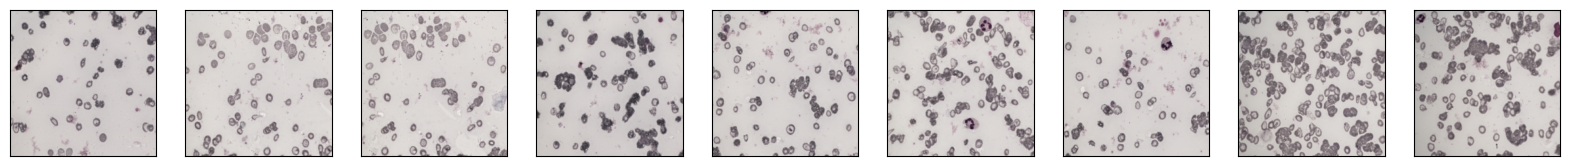

In [8]:
# Fetch first bag from the DataLoader
images, label = next(iter(data_loader))

print(f"Class: {'SMA' if label.item()==1 else 'non-SMA'}, Number of images: {len(images)}")

# Display all images from this bag
fig = plt.figure(figsize=(20, 10))  # adjust size as needed
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1, xticks=[], yticks=[])
    img = images[i].squeeze().permute(1, 2, 0)  
    ax.imshow(img.numpy())
plt.show()

In [36]:
# Iterate through the data loader
for images, label in data_loader:
    # Iterate through each image in the bag
    for i in range(len(images)):
        print(f"Image {i+1} dimensions: {images[i].size()}")

Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 2 dimensions: torch.Size([1, 3, 224, 224])
Image 3 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 2 dimensions: torch.Size([1, 3, 224, 224])
Image 3 dimensions: torch.Size([1, 3, 224, 224])
Image 4 dimensions: torch.Size([1, 3, 224, 224])
Image 5 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 2 dimensions: torch.Size([1, 3, 224, 224])
Image 3 dimensions: torch.Size([1, 3, 224, 224])
Image 4 dimensions: torch.Size([1, 3, 224, 224])
Image 5 dimensions: torch.Size([1, 3, 224, 224])
Image 6 dimensions: torch.Size([1, 3, 224, 224])
Image 7 dimensions: torch.Size([1, 3, 224, 224])
Image 8 dimensions: torch.Size([1, 3, 224, 224])
Image 9 dimensions: torch.Size([1, 3, 224, 224])
Image 10 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 2 dimensions: torch.Size([1, 3, 224, 224])
Image 3 dimensions:

KeyboardInterrupt: 